In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import zipfile

'''zip_path = 'preprocessed_data.zip'
extract_dir = 'preprocessed_data'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted '{zip_path}' to '{extract_dir}' successfully!")
else:
    print(f"'{zip_path}' not found, assuming data is already extracted.")'''

'zip_path = \'preprocessed_data.zip\'\nextract_dir = \'preprocessed_data\'\n\nif os.path.exists(zip_path):\n    with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n        zip_ref.extractall(extract_dir)\n    print(f"Extracted \'{zip_path}\' to \'{extract_dir}\' successfully!")\nelse:\n    print(f"\'{zip_path}\' not found, assuming data is already extracted.")'

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# -------------------------------
# Parameters
# -------------------------------
IMG_SIZE = 48
NUM_CLASSES = 8
DATA_DIR = '/content/drive/My Drive/ec523 project/data/affectnet'
#DATA_DIR = 'preprocessed_data'  # Folder containing the numpy arrays: X_train.npy, y_train.npy, X_val.npy, y_val.npy, X_test.npy, y_test.npy

# -------------------------------
# Load Preprocessed Data (Training, Validation & Test Sets)
# -------------------------------
def load_data(data_dir):
    X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
    y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
    X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data(DATA_DIR)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (201347, 48, 48, 1) (201347, 8)
Validation set: (43155, 48, 48, 1) (43155, 8)
Test set: (43148, 48, 48, 1) (43148, 8)


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def resnet_block(x, filters, kernel_size=3, stride=1):
    """
    A basic residual block with two convolutional layers.
    If stride != 1, the shortcut is adjusted with a 1x1 convolution.
    """
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    x = resnet_block(x, 16)
    x = resnet_block(x, 16)

    x = resnet_block(x, 32, stride=2)
    x = resnet_block(x, 32)

    x = resnet_block(x, 64, stride=2)
    x = resnet_block(x, 64)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (IMG_SIZE, IMG_SIZE, 1)
model = build_resnet(input_shape, NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 48, 48,    │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 48, 48,    │      2,320 │ activation_13[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 48, 48,    │      2,320 │ activation_14[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 48, 48,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 48, 48,    │      2,320 │ activation_15[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 48, 48,    │      2,320 │ activation_16[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 48, 48,    │          0 │ batch_normalizat

 Total params: 176,520 (689.53 KB)

 Trainable params: 175,400 (685.16 KB)

 Non-trainable params: 1,120 (4.38 KB)

In [14]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

LEARNING_RATE = 0.01
EPOCHS = 100
BATCH_SIZE = 128

sgd = SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

checkpoint = ModelCheckpoint("AffectNet_ResNet_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
rlrop = ReduceLROnPlateau(monitor='loss', mode='min', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
callbacks_list = [checkpoint, rlrop]

In [15]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    shuffle=True,
    validation_data=(X_val, y_val)
)


Epoch 1/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5411 - loss: 1.3152
Epoch 1: val_accuracy improved from -inf to 0.64146, saving model to AffectNet_ResNet_best.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 79s 43ms/step - accuracy: 0.5411 - loss: 1.3151 - val_accuracy: 0.6415 - val_loss: 1.0811 - learning_rate: 0.0100
Epoch 2/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6696 - loss: 0.9556
Epoch 2: val_accuracy improved from 0.64146 to 0.67306, saving model to AffectNet_ResNet_best.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.6696 - loss: 0.9556 - val_accuracy: 0.6731 - val_loss: 0.9669 - learning_rate: 0.0100
Epoch 3/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6959 - loss: 0.8771
Epoch 3: val_accuracy did not improve from 0.67306
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.6959 - loss: 0.8771 - val_accuracy: 0.5109 - val_loss: 1.4169 - learning_rate: 0.0100
Epoch 4/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7069 - loss: 0.8436
Epoch 4: val_accuracy improved from 0.67306 to 0.68722, saving model to AffectNet_ResNet_best.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 84s 40ms/step - accuracy: 0.7069 - loss: 0.8436 - val_accuracy: 0.6872 - val_loss: 0.9403 - learning_rate: 0.0100
Epoch 5/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7215 - loss: 0.7962
Epoch 5: val_accuracy improved from 0.68722 to 0.69834, saving model to AffectNet_ResNet_best.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.7215 - loss: 0.7962 - val_accuracy: 0.6983 - val_loss: 0.8667 - learning_rate: 0.0100
Epoch 6/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7315 - loss: 0.7694
Epoch 6: val_accuracy did not improve from 0.69834
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 39ms/step - accuracy: 0.7315 - loss: 0.7694 - val_accuracy: 0.6133 - val_loss: 1.0898 - learning_rate: 0.0100
Epoch 7/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7388 - loss: 0.7445
Epoch 7: val_accuracy did not improve from 0.69834
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7388 - loss: 0.7446 - val_accuracy: 0.6870 - val_loss: 0.9075 - learning_rate: 0.0100
Epoch 8/100
1572/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7439 - loss: 0.7321
Epoch 8: val_accuracy improved from 0.69834 to 0.70349, saving model to AffectNet_ResNet_best.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.7439 - loss: 0.7321 - val_accuracy: 0.7035 - val_loss: 0.8629 - learning_rate: 0.0100
Epoch 9/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7489 - loss: 0.7172
Epoch 9: val_accuracy did not improve from 0.70349
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.7489 - loss: 0.7172 - val_accuracy: 0.6908 - val_loss: 0.9279 - learning_rate: 0.0100
Epoch 10/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7540 - loss: 0.7001
Epoch 10: val_accuracy did not improve from 0.70349
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 60s 38ms/step - accuracy: 0.7540 - loss: 0.7001 - val_accuracy: 0.6535 - val_loss: 0.9972 - learning_rate: 0.0100
Epoch 11/100
1572/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7581 - loss: 0.6878
Epoch 11: val_accuracy did not improve from 0.70349
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 85s 40ms/step - accuracy: 0.7581 - loss: 0.6878 - val_accuracy: 0.5704 - val_loss: 1.2392 - learning_rate: 

1574/1574 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.7637 - loss: 0.6692 - val_accuracy: 0.7183 - val_loss: 0.8052 - learning_rate: 0.0100
Epoch 14/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7734 - loss: 0.6438
Epoch 14: val_accuracy did not improve from 0.71832
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7734 - loss: 0.6438 - val_accuracy: 0.6435 - val_loss: 1.1965 - learning_rate: 0.0100
Epoch 15/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7730 - loss: 0.6424
Epoch 15: val_accuracy did not improve from 0.71832
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7730 - loss: 0.6424 - val_accuracy: 0.5988 - val_loss: 1.1824 - learning_rate: 0.0100
Epoch 16/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7813 - loss: 0.6226
Epoch 16: val_accuracy did not improve from 0.71832
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 39ms/step - accuracy: 0.7813 - loss: 0.6226 - val_accuracy: 0.6396 - val_loss: 1.2805 - learning_rate

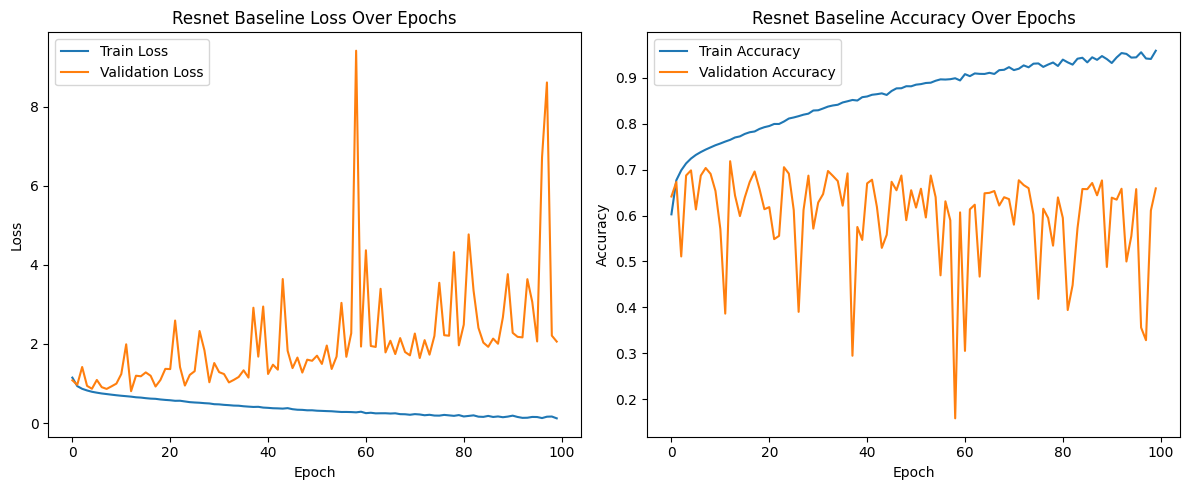

In [16]:
'''history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    shuffle=True,
    validation_data=(X_val, y_val)
)'''

import matplotlib
#matplotlib.use('Agg')  # 指定Agg后端，专门为保存图准备
#import matplotlib.pyplot as plt

# Plot training history: Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Resnet Baseline Loss Over Epochs')
plt.legend()
#plt.savefig('/content/drive/My Drive/ec523 project/figure_result/ResNet_Affectnet_loff_plot.png')


# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Resnet Baseline Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
#plt.show()

plt.savefig('/content/drive/My Drive/ec523 project/figure_result/ResNet_Affectnet_loss_and_accuracy_plot.png')
plt.show()
plt.close()



1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6620 - loss: 2.0731
Resnet Baseline Test loss: 2.048793077468872 Resnet Baseline Test accuracy: 0.6639241576194763
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6611 - loss: 2.0263
Resnet Baseline Val loss: 2.0596230030059814 Resnet Baseline Val accuracy: 0.6590893268585205
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


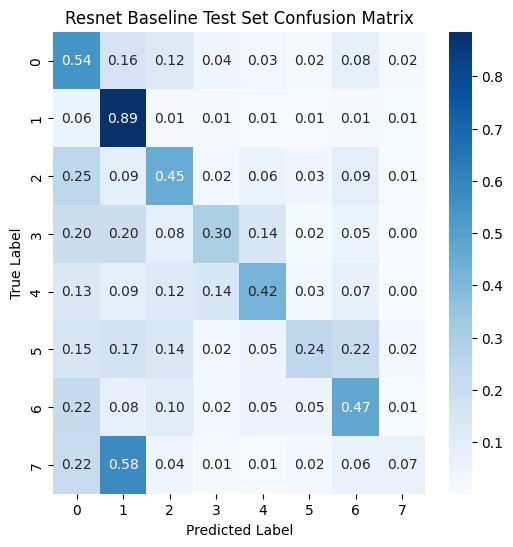

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Resnet Baseline Test loss:", test_loss, "Resnet Baseline Test accuracy:", test_acc)

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print("Resnet Baseline Val loss:", val_loss, "Resnet Baseline Val accuracy:", val_acc)
# Generate predictions and plot confusion matrix
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_true, y_test_pred_classes, normalize='true')
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')
plt.title("Resnet Baseline Test Set Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.show()
plt.savefig('/content/drive/My Drive/ec523 project/figure_result/ResNet_Affectnet_confusion_matrix.png')
plt.show()
plt.close()

In [18]:
model.save("/content/drive/My Drive/ec523 project/models/AffectNet_ResNet_final_model.h5")
print("Model saved as AffectNet_ResNet_final_model.h5")

Model saved as AffectNet_ResNet_final_model.h5
